In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
from scipy.stats import zscore

In [2]:
with open('/sietch_colab/akapoor/Demographic_Inference/sims_pretrain_5000_sims_inference_1_seed_42_num_replicates_3_top_values_2/postprocessing_results.pkl', 'rb') as f:
    postprocessing_results = pickle.load(f)

In [3]:
with open('/sietch_colab/akapoor/Demographic_Inference/sims_pretrain_5000_sims_inference_1_seed_42_num_replicates_3_top_values_2/preprocessing_results_obj.pkl', 'rb') as f:
    preprocessing_results_obj = pickle.load(f)

In [4]:
preprocessing_results_obj['training']['predictions']

,Moments_rep1_Na,Moments_rep1_N1,Moments_rep1_N2,Moments_rep1_t_split,Moments_rep1_m,Moments_rep1_ll,Moments_rep1_FIM_element_0,Moments_rep1_FIM_element_1,Moments_rep1_FIM_element_2,Moments_rep1_FIM_element_3,...,Dadi_rep2_N1,Dadi_rep2_N2,Dadi_rep2_t_split,Dadi_rep2_m,Dadi_rep2_ll,MomentsLD_N1,MomentsLD_N2,MomentsLD_t_split,MomentsLD_m,MomentsLD_Na
Sim_0,14547.235284,2299.864753,5990.511828,2151.741418,457.461763,-171248.339555,-1.415924e+07,-298621.665221,1.189807e+07,-1.404964e+05,...,2008.344057,3162.560286,1537.816319,425.940424,-131216.871217,9893.177443,1676.692491,1658.838363,7.018085e-07,13184.429188
Sim_1,17937.771858,2434.593339,16847.693790,3454.194594,1239.726433,-112361.858344,-2.290248e+07,-175340.190508,1.746063e+07,-4.467837e+05,...,2635.491472,7702.073828,1281.244710,634.688580,-106291.188886,6820.846716,8133.743717,4714.503053,5.386078e-07,19560.709979
Sim_2,6431.803520,916.885687,8094.972823,932.921486,390.666844,-116045.139599,-4.766160e+06,-279654.854726,3.007594e+07,-1.344479e+05,...,1229.944983,1.847242,2856.728874,732.972838,-173842.722910,1832.650902,361.940725,2152.860720,2.606634e-07,25248.317481
Sim_3,10718.926578,1612.647222,9338.256824,1025.310395,404.871226,-100900.825251,8.702306e+06,-625288.163686,3.866748e+07,-8.194386e+04,...,1.435924,5203.502145,1573.413602,1109.307709,-113618.467156,589.538749,7861.051008,3758.946588,1.239889e-07,14518.612424
Sim_4,14361.166788,822.272798,12880.538625,911.075194,665.892057,-57775.568353,-1.320994e+08,77075.892935,7.563650e+07,-5.262003e+05,...,1131.745946,7953.636645,2.554234,355.743710,-151274.211821,3077.185477,6039.775343,363.925633,7.981744e-07,13357.540352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sim_3995,12615.456674,912.463818,9740.136073,2134.634961,885.775642,-286091.783741,-8.126725e+07,-354392.351939,2.806072e+07,-5.043121e+05,...,2244.432749,3437.652628,1785.716845,364.919182,-128281.383579,7501.345376,2236.612963,4130.410180,7.542416e-07,13000.257713
Sim_3996,14396.008945,3075.284968,7549.442281,1997.821921,491.095114,-154497.883456,-6.469532e+06,-381381.997053,1.276249e+07,-6.390037e+04,...,3001.781949,3930.773691,1190.626671,692.223262,-120574.909450,7070.320524,1757.932802,1922.731442,5.876075e-07,15723.174084
Sim_3997,18324.816644,2828.821108,9102.926471,957.636410,617.929382,-291293.255819,-9.496744e+06,-986770.725425,6.805454e+07,8.945509e+04,...,3714.365745,4870.832608,2124.057584,874.375754,-92224.761340,9730.982000,2801.163188,2518.541312,5.174025e-07,19517.456526
Sim_3998,14508.850047,878.799681,10298.521691,2583.372092,697.563537,-193288.439815,-1.908992e+08,-205790.319245,4.214141e+07,-2.078767e+06,...,1948.679118,2797.160581,1310.912765,365.386711,-168492.328275,3415.036202,215.489338,162.460850,6.869979e-07,15323.823398


I want to make the postprocessing object look EXACTLY like the preprocessing object

In [36]:
import numpy as np
import pandas as pd
import json
from scipy.stats import zscore


def postprocessing(experiment_config, training_features, training_targets, validation_features, validation_targets):

    # Load data and config
    training_features = pd.read_csv(training_features, index_col=0)
    validation_features = pd.read_csv(validation_features, index_col=0)
    training_targets = pd.read_csv(training_targets, index_col=0)
    validation_targets = pd.read_csv(validation_targets, index_col=0)

    with open(experiment_config, "r") as f:
        experiment_config = json.load(f)

    postprocessing_dict = {
        'parameter_names': training_features.columns.tolist(),
        'target_names': training_targets.columns.tolist()
    }

    features_dict = {'training': training_features, 'validation': validation_features}
    targets_dict = {'training': training_targets, 'validation': validation_targets}

    # Define parameters to process
    param_types = ['Na', 'N1', 'N2', 't_split', 'm']

    for stage in ['training', 'validation']:
        features = features_dict[stage]
        targets = targets_dict[stage]
        outliers_imputed = None
        

        print(f"\nProcessing {stage} data:")

        if experiment_config['remove_outliers']:
            for param in param_types:
                # Get bounds
                lower_bound = experiment_config['lower_bound_params'].get(param)
                upper_bound = experiment_config['upper_bound_params'].get(param)

                if lower_bound is None or upper_bound is None:
                    continue

                # Find all columns ending with this parameter
                param_cols = [col for col in features.columns if col.endswith('_' + param)]
                
                for col in param_cols:
                    # Identify outliers
                    outlier_mask = (features[col] < lower_bound) | (features[col] > upper_bound)
                    valid_mask = ~outlier_mask

                    if outlier_mask.any():
                        # Use median of valid values only
                        valid_median = features.loc[valid_mask, col].median()
                        features.loc[outlier_mask, col] = valid_median
                        # print(f"{col}: Replaced {outlier_mask.sum()} outliers. New range: [{features[col].min():.3f}, {features[col].max():.3f}]")

            outliers_imputed = features.copy()

        if experiment_config['normalization']:
            print("===> Normalizing the data.")
            
            # Normalize targets column by column using corresponding bounds
            normalized_targets = targets.copy()
            for param in experiment_config['parameter_names']:
                lower_bound = experiment_config['lower_bound_params'][param]
                upper_bound = experiment_config['upper_bound_params'][param]
                mean = 0.5 * (upper_bound + lower_bound)
                std = (upper_bound - lower_bound) / np.sqrt(12)
                target_col = f'simulated_params_{param}'
                normalized_targets[target_col] = (targets[target_col] - mean) / std
            
            # Normalize parameter features using same bounds
            features_copy = features.copy()
            for param in ['Na', 'N1', 'N2', 't_split', 'm']:
                param_cols = [col for col in features.columns if col.endswith('_' + param)]
                lower_bound = experiment_config['lower_bound_params'][param]
                upper_bound = experiment_config['upper_bound_params'][param]
                mean = 0.5 * (upper_bound + lower_bound)
                std = (upper_bound - lower_bound) / np.sqrt(12)
                
                for col in param_cols:
                    features_copy[col] = (features[col] - mean) / std

            postprocessing_dict[stage] = {
                "normalization": experiment_config['normalization'],
                "predictions": outliers_imputed if outliers_imputed is not None else features_dict[stage],
                "normalized_predictions": features_copy,
                "targets": targets,
                "normalized_targets": normalized_targets
            }
            
        else:
            postprocessing_dict[stage] = {
                "normalization": experiment_config['normalization'],
                "predictions": outliers_imputed if outliers_imputed is not None else features_dict[stage],
                "normalized_predictions": None,
                "targets": targets,
                "normalized_targets": None
            }

    return postprocessing_dict



In [37]:
experiment_config = '/sietch_colab/akapoor/Demographic_Inference/experiment_config.json'
training_features = '/sietch_colab/akapoor/Demographic_Inference/sims_pretrain_5000_sims_inference_1_seed_42_num_replicates_3_top_values_2/training_features.csv'
training_targets = '/sietch_colab/akapoor/Demographic_Inference/sims_pretrain_5000_sims_inference_1_seed_42_num_replicates_3_top_values_2/training_targets.csv'
validation_features = '/sietch_colab/akapoor/Demographic_Inference/sims_pretrain_5000_sims_inference_1_seed_42_num_replicates_3_top_values_2/validation_features.csv'
validation_targets = '/sietch_colab/akapoor/Demographic_Inference/sims_pretrain_5000_sims_inference_1_seed_42_num_replicates_3_top_values_2/validation_targets.csv'

In [38]:
postprocessing_dict = postprocessing(experiment_config, training_features, training_targets, validation_features, validation_targets)


Processing training data:
===> Normalizing the data.

Processing validation data:
===> Normalizing the data.


Text(0, 0.5, 'True')

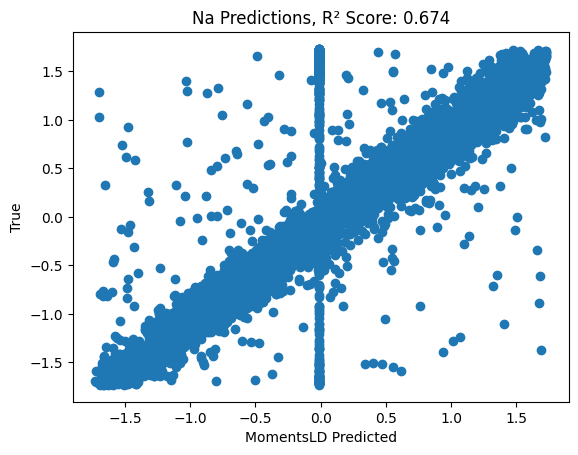

In [51]:
plt.figure()
plt.scatter(postprocessing_dict['training']['normalized_predictions']['MomentsLD_Na'],postprocessing_dict['training']['normalized_targets']['simulated_params_Na'] )

r2 = r2_score(postprocessing_dict['training']['normalized_predictions']['MomentsLD_Na'],
              postprocessing_dict['training']['normalized_targets']['simulated_params_Na']
              )

plt.title(f'Na Predictions, R² Score: {r2:.3f}')
plt.xlabel('MomentsLD Predicted')
plt.ylabel('True')

In [46]:
postprocessing_dict['training']['normalized_predictions']['MomentsLD_N1']

Sim_0       1.694673
Sim_1       0.619636
Sim_2      -1.125780
Sim_3      -1.560757
Sim_4      -0.690306
              ...   
Sim_3995    0.857748
Sim_3996    0.706929
Sim_3997    1.637919
Sim_3998   -0.572089
Sim_3999   -0.007247
Name: MomentsLD_N1, Length: 4000, dtype: float64

In [47]:
postprocessing_dict['training']['normalized_targets']['simulated_params_N1']

Sim_0       1.495162
Sim_1       0.640684
Sim_2      -0.862526
Sim_3      -1.581590
Sim_4      -0.629137
              ...   
Sim_3995    0.796044
Sim_3996    0.617940
Sim_3997    1.588238
Sim_3998   -0.556706
Sim_3999   -1.164148
Name: simulated_params_N1, Length: 4000, dtype: float64

Text(0, 0.5, 'True')

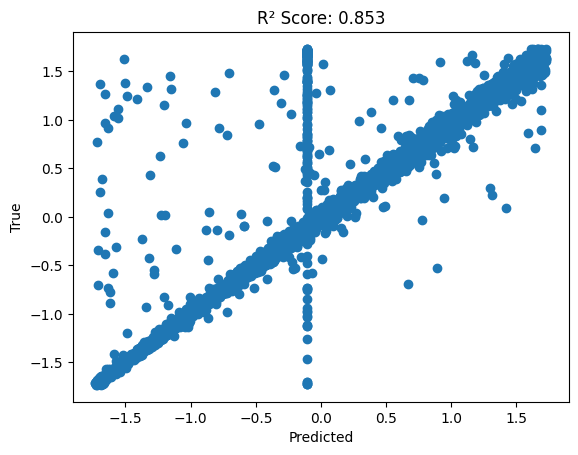

In [49]:
plt.figure()
plt.scatter(postprocessing_dict['training']['normalized_predictions']['MomentsLD_t_split'],postprocessing_dict['training']['normalized_targets']['simulated_params_t_split'] )

r2 = r2_score(postprocessing_dict['training']['normalized_predictions']['MomentsLD_t_split'],
              postprocessing_dict['training']['normalized_targets']['simulated_params_t_split']
              )

plt.title(f'R² Score: {r2:.3f}')
plt.xlabel('Predicted')
plt.ylabel('True')

In [57]:
postprocessing_dict['training']['normalized_predictions'].columns

Index(['Moments_rep1_Na', 'Moments_rep1_N1', 'Moments_rep1_N2',
       'Moments_rep1_t_split', 'Moments_rep1_m', 'Moments_rep1_ll',
       'Moments_rep1_FIM_element_0', 'Moments_rep1_FIM_element_1',
       'Moments_rep1_FIM_element_2', 'Moments_rep1_FIM_element_3',
       'Moments_rep1_FIM_element_4', 'Moments_rep1_FIM_element_5',
       'Moments_rep1_FIM_element_6', 'Moments_rep1_FIM_element_7',
       'Moments_rep1_FIM_element_8', 'Moments_rep1_FIM_element_9',
       'Moments_rep2_Na', 'Moments_rep2_N1', 'Moments_rep2_N2',
       'Moments_rep2_t_split', 'Moments_rep2_m', 'Moments_rep2_ll',
       'Moments_rep2_FIM_element_0', 'Moments_rep2_FIM_element_1',
       'Moments_rep2_FIM_element_2', 'Moments_rep2_FIM_element_3',
       'Moments_rep2_FIM_element_4', 'Moments_rep2_FIM_element_5',
       'Moments_rep2_FIM_element_6', 'Moments_rep2_FIM_element_7',
       'Moments_rep2_FIM_element_8', 'Moments_rep2_FIM_element_9',
       'Dadi_rep1_Na', 'Dadi_rep1_N1', 'Dadi_rep1_N2', 'Dadi_rep1_

In [58]:
postprocessing_dict['training']['normalized_targets'].columns

Index(['simulated_params_t_split', 'simulated_params_N1',
       'simulated_params_N2', 'simulated_params_Na', 'simulated_params_m'],
      dtype='object')

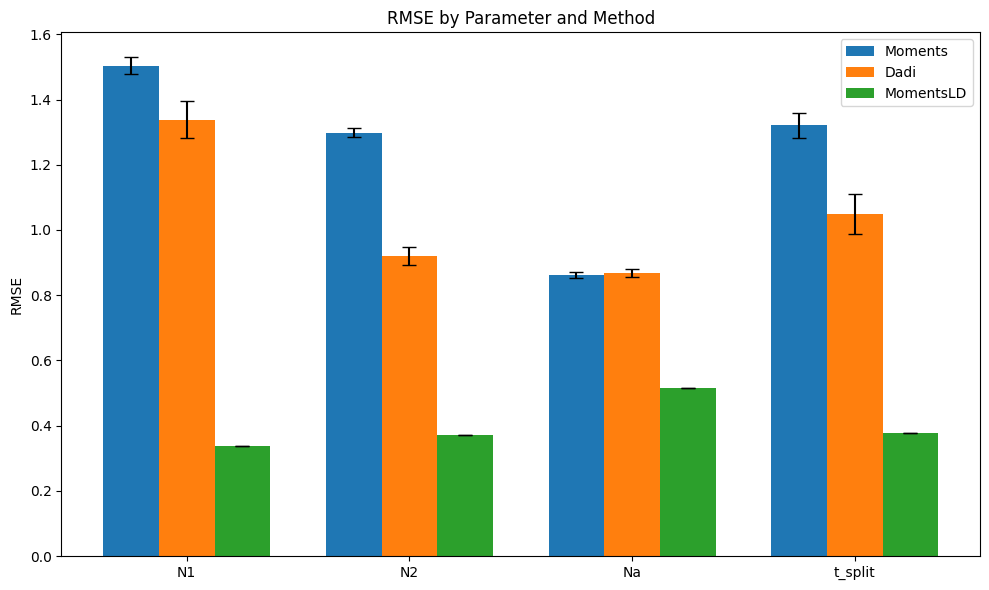

In [60]:
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Calculate RMSE and standard errors for each parameter and method
params = ['N1', 'N2', 'Na', 't_split']
methods = ['Moments', 'Dadi', 'MomentsLD']
rmse_values = {}
rmse_errors = {}

for param in params:
   rmse_values[param] = {}
   rmse_errors[param] = {}
   target_col = f'simulated_params_{param}'
   target_values = postprocessing_dict['training']['normalized_targets'][target_col]
   
   for method in methods:
       if method == 'Moments':
           # Get RMSE for each replicate
           rep1_rmse = np.sqrt(mean_squared_error(target_values, 
                             postprocessing_dict['training']['normalized_predictions'][f'Moments_rep1_{param}']))
           rep2_rmse = np.sqrt(mean_squared_error(target_values, 
                             postprocessing_dict['training']['normalized_predictions'][f'Moments_rep2_{param}']))
           
           rmse_values[param][method] = np.mean([rep1_rmse, rep2_rmse])
           rmse_errors[param][method] = np.std([rep1_rmse, rep2_rmse]) / np.sqrt(2)  # Standard error
       
       elif method == 'Dadi':
           # Get RMSE for each replicate
           rep1_rmse = np.sqrt(mean_squared_error(target_values, 
                             postprocessing_dict['training']['normalized_predictions'][f'Dadi_rep1_{param}']))
           rep2_rmse = np.sqrt(mean_squared_error(target_values, 
                             postprocessing_dict['training']['normalized_predictions'][f'Dadi_rep2_{param}']))
           
           rmse_values[param][method] = np.mean([rep1_rmse, rep2_rmse])
           rmse_errors[param][method] = np.std([rep1_rmse, rep2_rmse]) / np.sqrt(2)  # Standard error
       
       else:  # MomentsLD
           rmse_values[param][method] = np.sqrt(mean_squared_error(target_values, 
                                              postprocessing_dict['training']['normalized_predictions'][f'MomentsLD_{param}']))
           rmse_errors[param][method] = 0  # No replicates for MomentsLD

# Create grouped bar plot
x = np.arange(len(params))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))

# Create bars with error bars
rects1 = ax.bar(x - width, [rmse_values[p]['Moments'] for p in params], width, 
               yerr=[rmse_errors[p]['Moments'] for p in params],
               label='Moments', capsize=5)
rects2 = ax.bar(x, [rmse_values[p]['Dadi'] for p in params], width,
               yerr=[rmse_errors[p]['Dadi'] for p in params],
               label='Dadi', capsize=5)
rects3 = ax.bar(x + width, [rmse_values[p]['MomentsLD'] for p in params], width,
               yerr=[rmse_errors[p]['MomentsLD'] for p in params],
               label='MomentsLD', capsize=5)

ax.set_ylabel('RMSE')
ax.set_title('RMSE by Parameter and Method')
ax.set_xticks(x)
ax.set_xticklabels(params)
ax.legend()

plt.tight_layout()
plt.show()